In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
import numpy as np

In [2]:
df = pd.read

Files already downloaded and verified


In [3]:
import torch
import torch.nn as nn

class SimpleNN(nn.Module):
   def __init__(self):
      super(SimpleNN, self).__init__()
      self.fc1 = nn.Linear(32 * 32 * 3, 256)
      self.fc2 = nn.Linear(256, 128)
      self.fc3 = nn.Linear(128, 10)
      self.relu = nn.ReLU()

   def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return x

In [4]:
model = SimpleNN()
model = model.to(device)

k = 5   
kf = KFold(n_splits=k)
accuracies = []

for train_idx, test_idx in kf.split(dataset):
 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.02, weight_decay=1e-5)

    train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=64, shuffle=True)
    test_loader = DataLoader(torch.utils.data.Subset(dataset, test_idx), batch_size=64, shuffle=False)

    for epoch in range(15):
        running_loss = 0.0

        for images, labels in train_loader:
    
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
        
            outputs = model(images.view(images.size(0), -1))
        
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item() * images.size(0)

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
    
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images.view(images.size(0), -1))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)

print(f'Mean Accuracy: {np.mean(accuracies)}%')
print(f'Standard Deviation: {np.std(accuracies)}%')

Mean Accuracy: 69.08%
Standard Deviation: 12.666271748229628%


In [5]:
test = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

test_loader = DataLoader(torch.utils.data.Subset(test, test_idx), batch_size=64, shuffle=False)

Files already downloaded and verified


In [24]:
from sklearn.metrics import f1_score, classification_report

model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

print("\nClassification Report:")
print(classification_report(all_labels, all_predictions))



Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1014
           1       0.94      0.92      0.93      1014
           2       0.78      0.80      0.79       952
           3       0.82      0.79      0.80      1016
           4       0.79      0.88      0.83       997
           5       0.83      0.83      0.83      1025
           6       0.93      0.86      0.89       980
           7       0.95      0.88      0.91       977
           8       0.95      0.91      0.93      1003
           9       0.88      0.94      0.91      1022

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



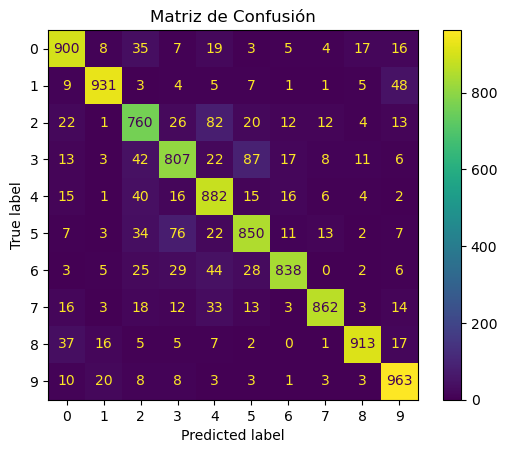

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title('Matriz de Confusión')
plt.show()


C:\Users\acasalro\AppData\Local\Temp\ipykernel_2952\2979569971.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('nipy_spectral', n_classes)


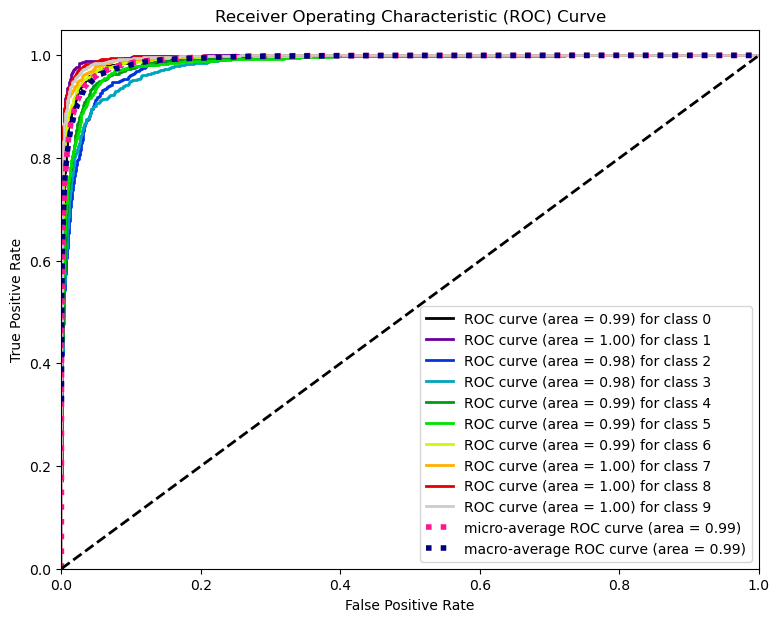

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

model.eval()

all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

n_classes = all_probs.shape[1]
all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(9,7))

colors = plt.cm.get_cmap('nipy_spectral', n_classes)

for i, color in zip(range(n_classes), colors(np.linspace(0, 1, n_classes))):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {i}')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
